In [14]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import uniform, randint
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn.linear_model import LogisticRegression
import sklearn.ensemble as ske
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing as skp

from pprint import pprint
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)


In [16]:

!ls /content/drive/MyDrive/dataset

data.csv  features_30_sec.csv  genres  images


In [17]:
df = pd.read_csv('/content/drive/MyDrive/dataset/data.csv')
df.head(100)

filename  length  chroma_stft_mean  ...  mfcc20_mean  mfcc20_var  label
0   blues.00000.0.wav   66149          0.335406  ...    -0.243027   43.771767  blues
1   blues.00000.1.wav   66149          0.343065  ...     5.784063   59.943081  blues
2   blues.00000.2.wav   66149          0.346815  ...     2.517375   33.105122  blues
3   blues.00000.3.wav   66149          0.363639  ...     3.630866   32.023678  blues
4   blues.00000.4.wav   66149          0.335579  ...     0.536961   29.146694  blues
..                ...     ...               ...  ...          ...         ...    ...
95  blues.00009.5.wav   66149          0.318541  ...    -0.551058   32.386032  blues
96  blues.00009.6.wav   66149          0.282178  ...    -8.579774   34.291157  blues
97  blues.00009.7.wav   66149          0.316982  ...    -4.615387   18.787031  blues
98  blues.00009.8.wav   66149          0.304123  ...    -0.659919   73.471901  blues
99  blues.00009.9.wav   66149          0.214538  ...    -0.465758  108.709732  blues

[100 rows x 60 columns]

In [18]:
print("Dataset has",df.shape)
df.label.value_counts().reset_index()

Dataset has (9990, 60)


index  label
0        pop   1000
1      blues   1000
2       jazz   1000
3      metal   1000
4     reggae   1000
5      disco    999
6     hiphop    998
7       rock    998
8  classical    998
9    country    997

In [19]:
audio_fp = '/content/drive/MyDrive/dataset/genres/disco/disco.00004.wav'
audio_data, sr = librosa.load(audio_fp, offset=0, duration=30)

# the result is an numpy ndarray
print('Audio File:', audio_data, '\n')


Audio File: [ 0.00262451  0.01730347 -0.01803589 ...  0.08956909  0.09320068
  0.0062561 ] 



In [20]:
audio_data, _ = librosa.effects.trim(audio_data)
audio_data.shape

(661500,)

In [21]:
collection = np.split(audio_data,10)

In [22]:
# play sample file
IPython.display.Audio(audio_data, rate=sr)

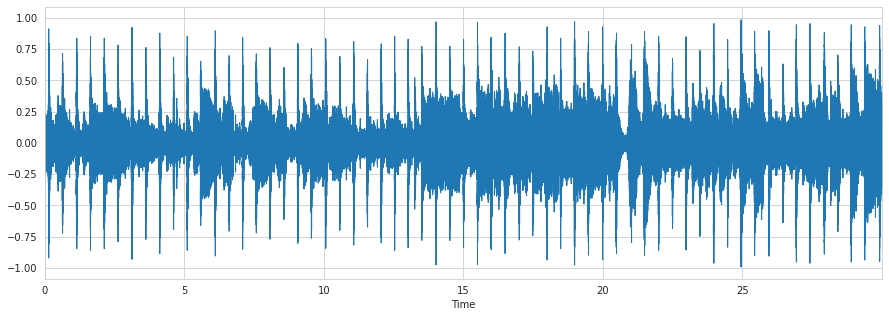

In [23]:
plt.figure(figsize=(15,5))
lplt.waveplot(audio_data)
plt.show()

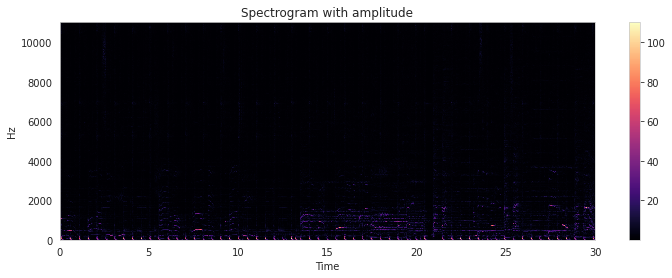

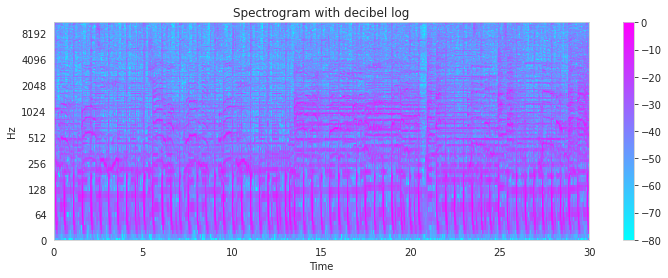

In [24]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()


In [25]:
# Calculate the Magnitude (abs values on complex numbers)
spectrogram = np.abs(stft)
# Short-time Fourier transform (STFT)
E = np.abs(librosa.stft(audio_data, n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(E))

Shape of D object: (1025, 1292)


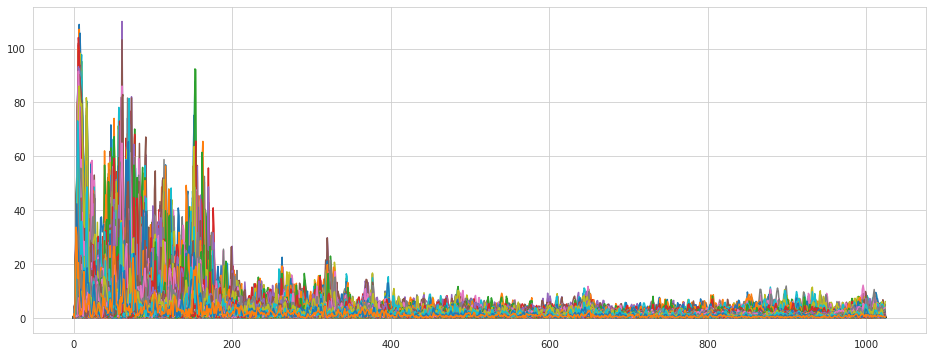

In [26]:
plt.figure(figsize = (16, 6))
plt.plot(E);

In [27]:
# Apply Logarithm to get values in Decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)
FIG_SIZE=(16,6)

Text(0.5, 1.0, 'Spectrogram (dB)')

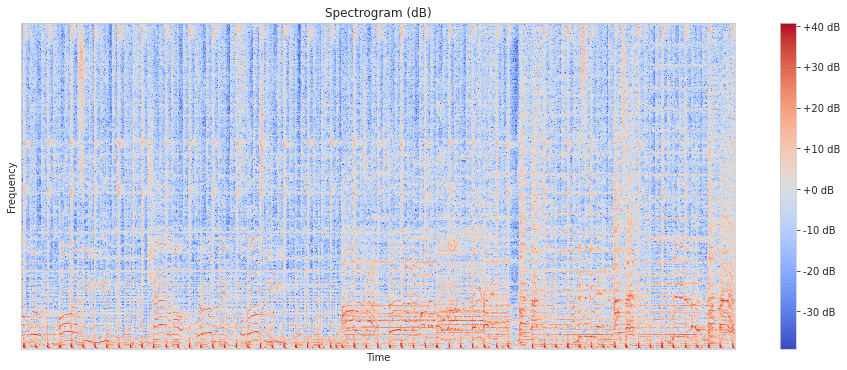

In [28]:
# Plot the Spectrogram in Decibels
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

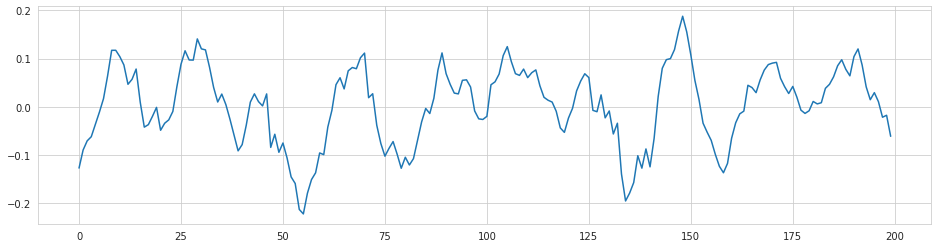

In [29]:
# plot zoomed audio wave 
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.show()

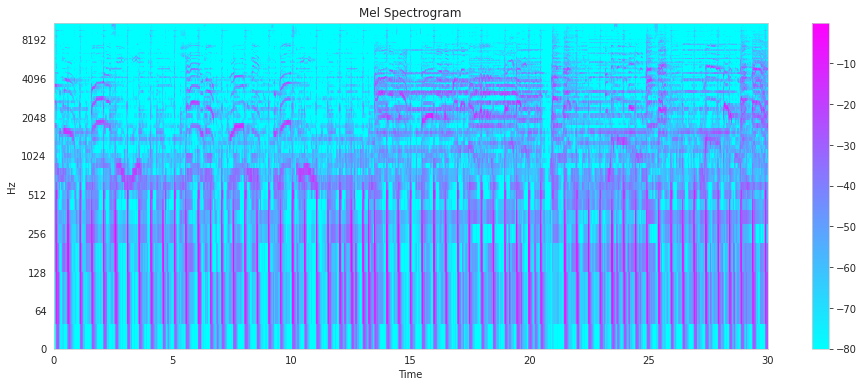

In [30]:
mel_spec = librosa.feature.melspectrogram(audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()


In [31]:
FIG_SIZE=(16,8)

Text(0.5, 1.0, 'MFCCs')

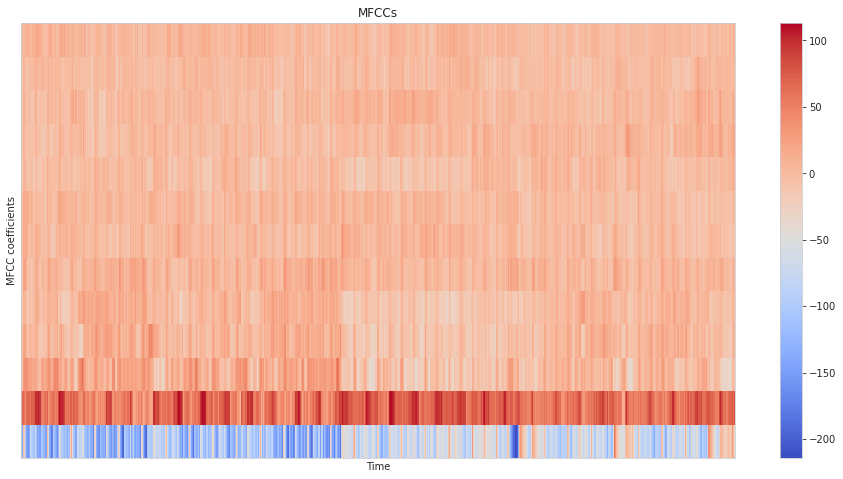

In [32]:
 #MFCCs (we are using 13 MFCCs)
MFCCs = librosa.feature.mfcc(audio_data, sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# Plot MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

Mean: 1.8169551e-09 

Var: 1.0000001


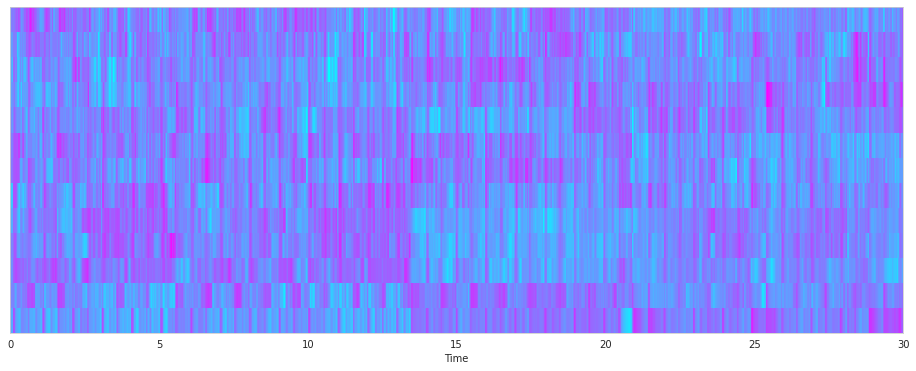

In [33]:
# Perform Feature Scaling
import sklearn
MFCCs = sklearn.preprocessing.scale(MFCCs, axis=1)
print('Mean:', MFCCs.mean(), '\n')
print('Var:', MFCCs.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(MFCCs, sr=sr, x_axis='time', cmap = 'cool');

Chromogram shape: (12, 133)


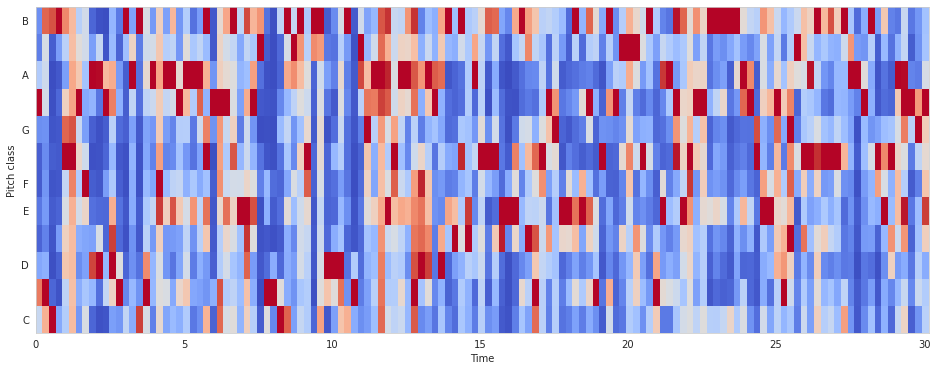

In [34]:
#chroma frequencies
# Increase or decrease hop_length to change how granular you want your data to be
hop_length = 5000

# Chromogram
chromagram = librosa.feature.chroma_stft(audio_data, sr=sr, hop_length=hop_length)
print('Chromogram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm');

In [35]:
# Total zero_crossings in our song
zero_crossings = librosa.zero_crossings(audio_data, pad=False)
print(sum(zero_crossings))

111956


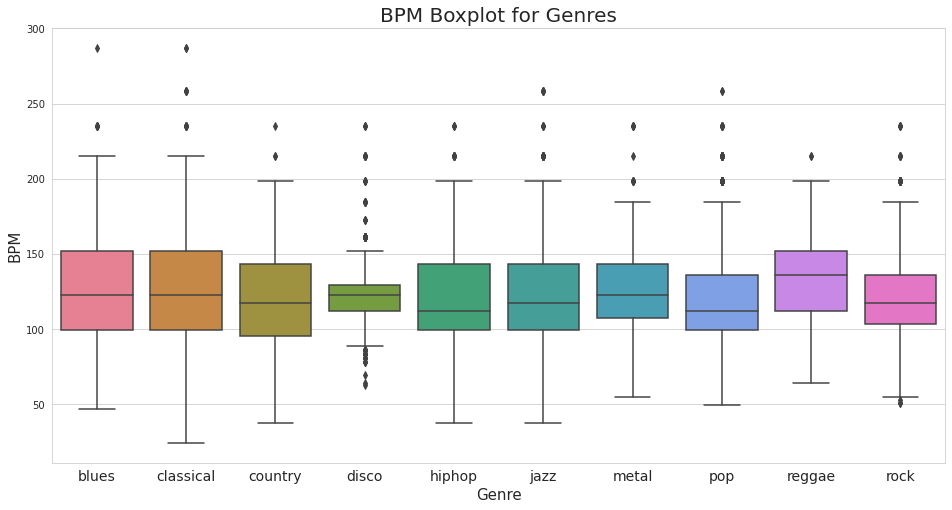

In [36]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

In [37]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


In [38]:
#### PCA calculation for 2 COMPONENTS ####
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_



array([0.26745621, 0.18238003])

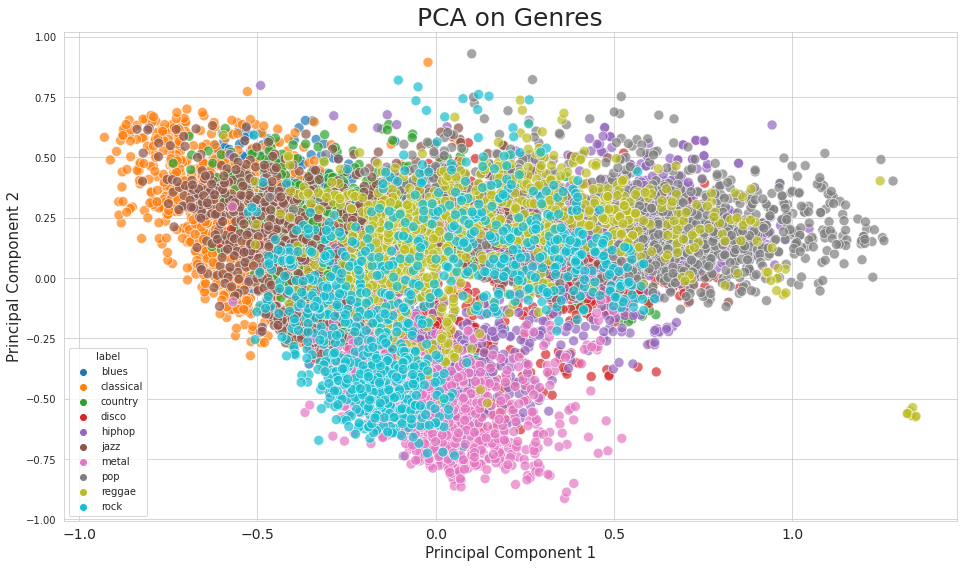

In [39]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA on Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA Scattert.jpg")


In [40]:
# find all columns with any NA values
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


In [41]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [42]:
df.label=[label_index[l] for l in df.label]

In [43]:
#split train,test and validation datasets
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle




In [44]:
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_validation, X_test, y_validation, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [45]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"validation set has {X_validation.shape[0]} records out of {len(df_shuffle)} which is {round(X_validation.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
validation set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [46]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_validation.value_counts()[0]/y_validation.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

10.01001001001001
10.010111223458038
10.009813542688912


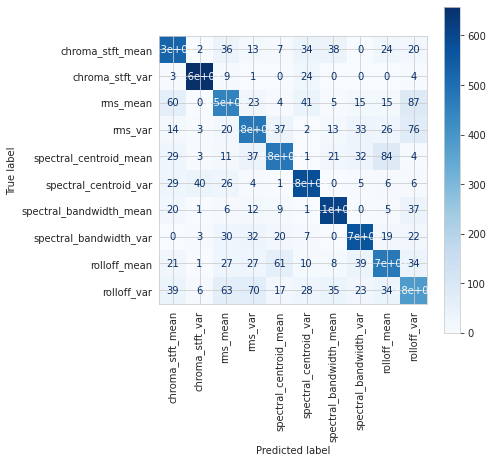

              precision    recall  f1-score   support

           0      0.710     0.751     0.730       700
           1      0.918     0.941     0.929       699
           2      0.663     0.642     0.652       698
           3      0.684     0.680     0.682       699
           4      0.754     0.682     0.716       699
           5      0.798     0.833     0.815       700
           6      0.835     0.870     0.852       700
           7      0.794     0.810     0.802       700
           8      0.689     0.674     0.682       700
           9      0.569     0.549     0.559       698

    accuracy                          0.743      6993
   macro avg      0.741     0.743     0.742      6993
weighted avg      0.741     0.743     0.742      6993



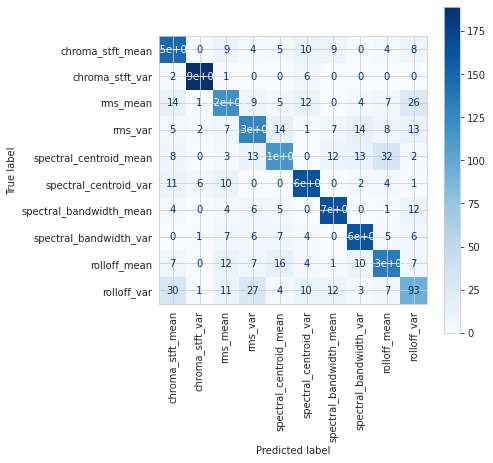

              precision    recall  f1-score   support

           0      0.648     0.753     0.696       198
           1      0.945     0.955     0.950       198
           2      0.650     0.604     0.626       197
           3      0.638     0.641     0.640       198
           4      0.671     0.579     0.621       197
           5      0.777     0.828     0.802       198
           6      0.802     0.838     0.820       198
           7      0.779     0.818     0.798       198
           8      0.663     0.677     0.670       198
           9      0.554     0.470     0.508       198

    accuracy                          0.716      1978
   macro avg      0.713     0.716     0.713      1978
weighted avg      0.713     0.716     0.713      1978



In [47]:
#Scaling the features
scaler=skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_validation = pd.DataFrame(scaler.transform(X_validation), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

def predictProba(clf, X, validation=False):
    y_true = y_train
    if validation:
        X = X_validation[X.columns]
        y_true = y_validation
    y_pred_proba_X = clf.predict_proba(X)
    y_pred_X = clf.predict(X)
    fig, ax = plt.subplots(figsize=(6, 6))
    skm.plot_confusion_matrix(clf, X, y_true, display_labels=X.columns, cmap=plt.cm.Blues, xticks_rotation=90, ax=ax)
    plt.show()
    print(skm.classification_report(y_true, y_pred_X, digits=3))
    print("=====================================================")

lr = LogisticRegression(random_state=seed)
lr.fit(X_train,y_train)
predictProba(lr, X_train)
predictProba(lr, X_train, validation=True)



In [48]:
#feature importance,Here we are using Permutation Importance
!pip install eli5


     |████████████████████████████████| 112kB 27.1MB/s 


In [49]:
import eli5
from eli5.sklearn import PermutationImportance

In [50]:
perm = PermutationImportance(lr, random_state=seed).fit(X_train, y_train, n_iter=10)
print("Feature Importances using Permutation Importance")
eli5.show_weights(perm, feature_names = X_validation.columns.tolist())

Feature Importances using Permutation Importance


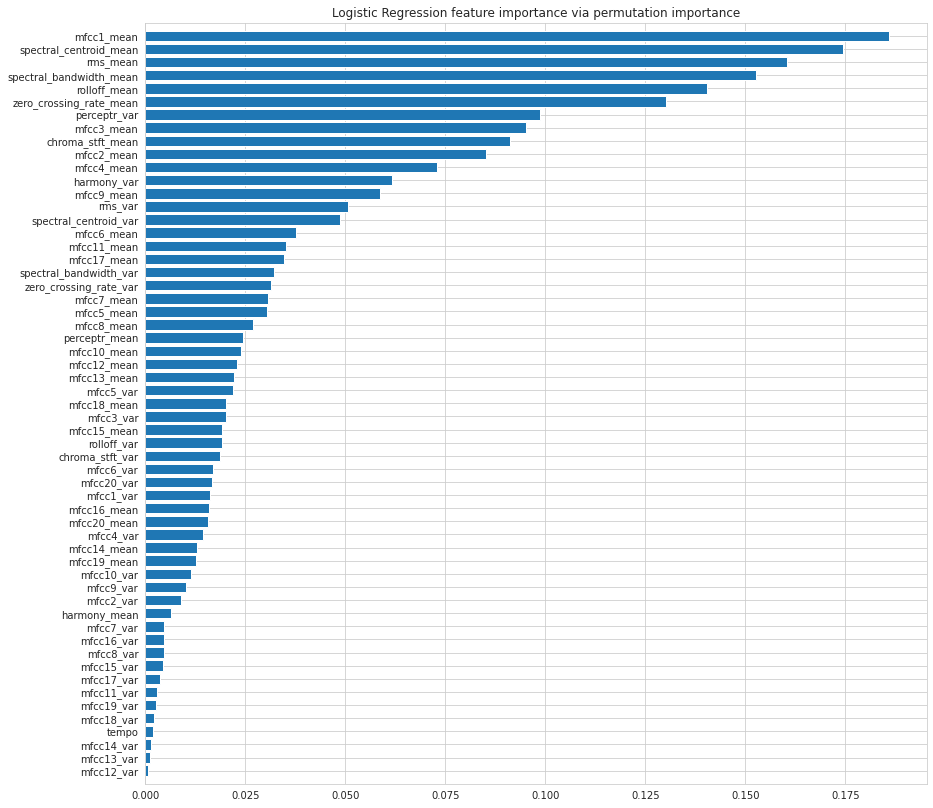

In [51]:
# plot the permutation importances
perm_indices = np.argsort(perm.feature_importances_)[::-1]
perm_features = [X_validation.columns.tolist()[xx] for xx in perm_indices]
plt.figure(figsize=(14, 14))
plt.title("Logistic Regression feature importance via permutation importance")
plt.barh(range(X_validation.shape[1]), perm.feature_importances_[perm_indices])
plt.yticks(range(X_validation.shape[1]), perm_features)
plt.ylim([X_validation.shape[1], -1])
plt.show()


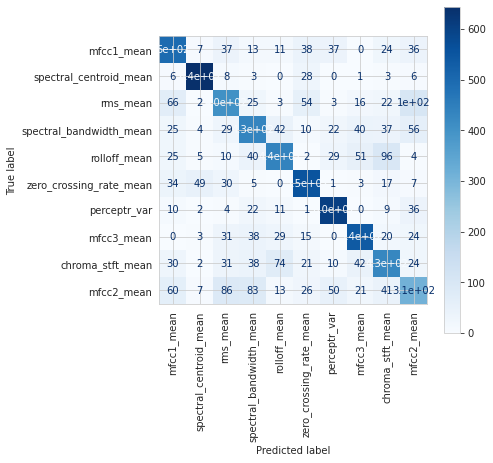

              precision    recall  f1-score   support

           0      0.660     0.710     0.684       700
           1      0.888     0.921     0.904       699
           2      0.604     0.580     0.592       698
           3      0.619     0.621     0.620       699
           4      0.705     0.625     0.663       699
           5      0.740     0.791     0.765       700
           6      0.799     0.864     0.830       700
           7      0.756     0.771     0.764       700
           8      0.614     0.611     0.613       700
           9      0.513     0.446     0.477       698

    accuracy                          0.694      6993
   macro avg      0.690     0.694     0.691      6993
weighted avg      0.690     0.694     0.691      6993



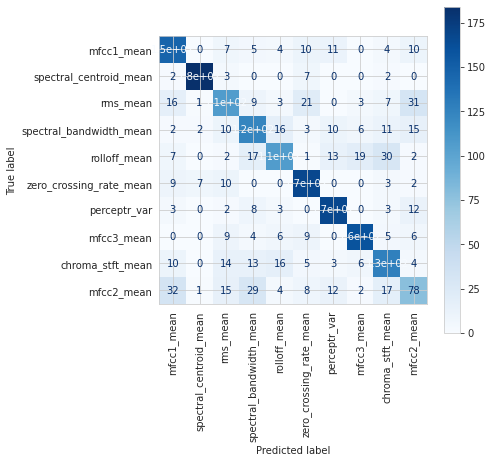

              precision    recall  f1-score   support

           0      0.645     0.742     0.690       198
           1      0.944     0.929     0.936       198
           2      0.596     0.538     0.565       197
           3      0.591     0.621     0.606       198
           4      0.671     0.538     0.597       197
           5      0.723     0.843     0.779       198
           6      0.773     0.843     0.807       198
           7      0.815     0.803     0.809       198
           8      0.608     0.641     0.624       198
           9      0.487     0.394     0.436       198

    accuracy                          0.690      1978
   macro avg      0.685     0.689     0.685      1978
weighted avg      0.685     0.690     0.685      1978



In [52]:
#model score using permutation importance
# build model using perm selected top 30 features
lr = LogisticRegression()
X_train_perm = X_train[perm_features[:30]]
X_train_rfe = X_train_perm
lr.fit(X_train_perm,y_train)
predictProba(lr, X_train_perm)
predictProba(lr, X_train_perm, validation=True)

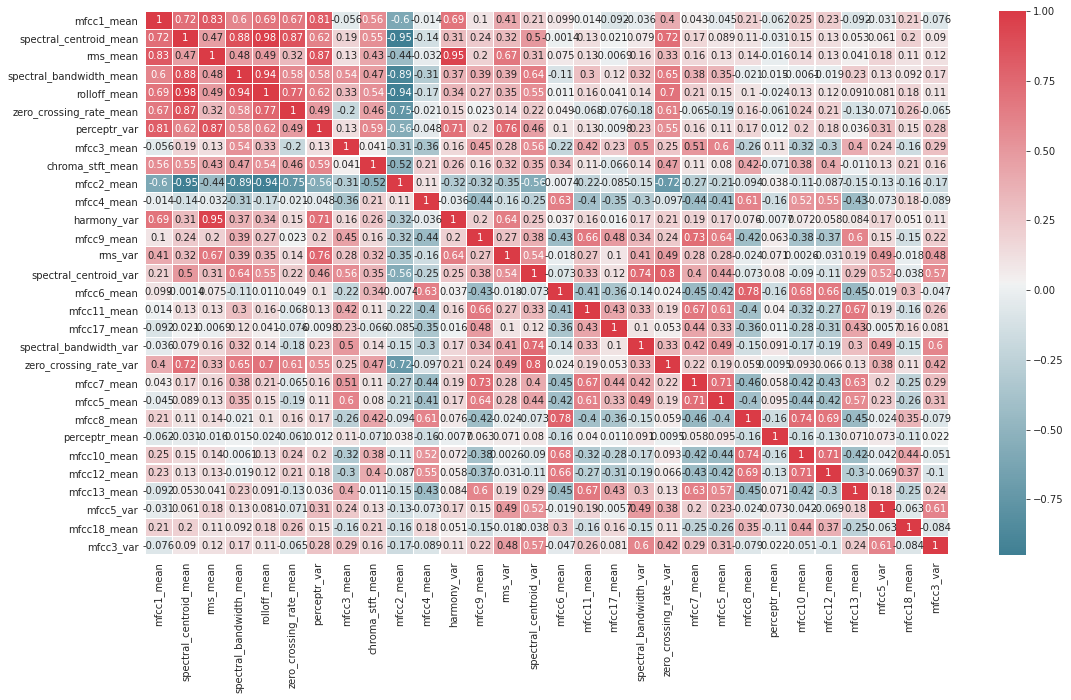

In [53]:
#plot correlation among top 30 selected featuers
plt.figure(figsize = (18, 10))
sns.heatmap(X_train_perm.corr(method='spearman'), annot = True, linewidths=.2, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

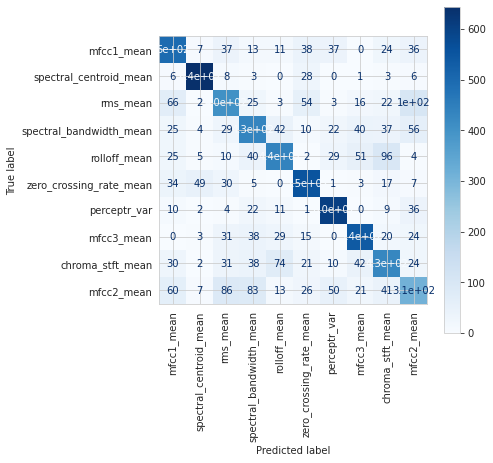

              precision    recall  f1-score   support

           0      0.660     0.710     0.684       700
           1      0.888     0.921     0.904       699
           2      0.604     0.580     0.592       698
           3      0.619     0.621     0.620       699
           4      0.705     0.625     0.663       699
           5      0.740     0.791     0.765       700
           6      0.799     0.864     0.830       700
           7      0.756     0.771     0.764       700
           8      0.614     0.611     0.613       700
           9      0.513     0.446     0.477       698

    accuracy                          0.694      6993
   macro avg      0.690     0.694     0.691      6993
weighted avg      0.690     0.694     0.691      6993



In [54]:
#model building
lr = LogisticRegression()
lr.fit(X_train_rfe,y_train)
predictProba(lr, X_train_rfe)


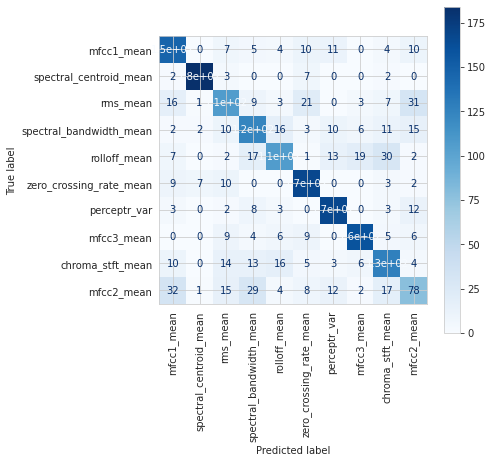

              precision    recall  f1-score   support

           0      0.645     0.742     0.690       198
           1      0.944     0.929     0.936       198
           2      0.596     0.538     0.565       197
           3      0.591     0.621     0.606       198
           4      0.671     0.538     0.597       197
           5      0.723     0.843     0.779       198
           6      0.773     0.843     0.807       198
           7      0.815     0.803     0.809       198
           8      0.608     0.641     0.624       198
           9      0.487     0.394     0.436       198

    accuracy                          0.690      1978
   macro avg      0.685     0.689     0.685      1978
weighted avg      0.685     0.690     0.685      1978



In [55]:
predictProba(lr, X_train_rfe, True)

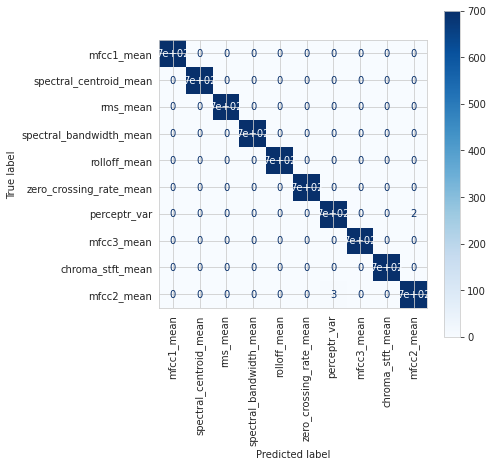

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       700
           1      1.000     1.000     1.000       699
           2      1.000     1.000     1.000       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      1.000     1.000     1.000       700
           6      0.996     0.997     0.996       700
           7      1.000     1.000     1.000       700
           8      1.000     1.000     1.000       700
           9      0.997     0.996     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [56]:
# random forest
rfc = ske.RandomForestClassifier(random_state=seed, n_jobs=-1)
rfc.fit(X_train_rfe, y_train)
predictProba(rfc, X_train_rfe)

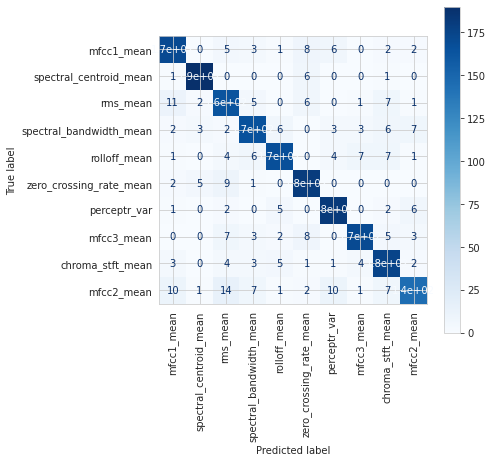

              precision    recall  f1-score   support

           0      0.847     0.864     0.855       198
           1      0.945     0.960     0.952       198
           2      0.777     0.832     0.804       197
           3      0.856     0.838     0.847       198
           4      0.893     0.848     0.870       197
           5      0.854     0.914     0.883       198
           6      0.883     0.919     0.901       198
           7      0.914     0.859     0.885       198
           8      0.825     0.884     0.854       198
           9      0.868     0.732     0.795       198

    accuracy                          0.865      1978
   macro avg      0.866     0.865     0.865      1978
weighted avg      0.866     0.865     0.865      1978



In [57]:
predictProba(rfc, X_train_rfe, True)

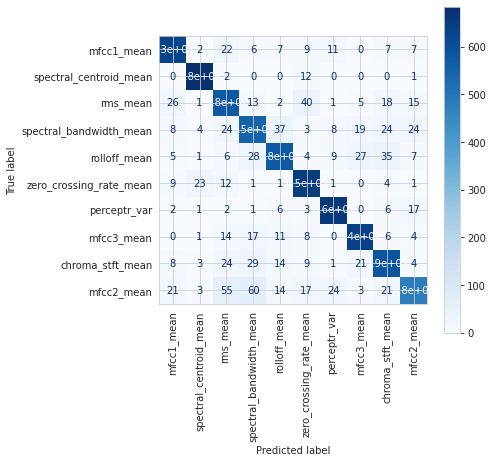

              precision    recall  f1-score   support

           0      0.888     0.899     0.893       700
           1      0.946     0.979     0.962       699
           2      0.782     0.827     0.804       698
           3      0.780     0.784     0.782       699
           4      0.862     0.825     0.844       699
           5      0.861     0.926     0.892       700
           6      0.923     0.946     0.934       700
           7      0.895     0.913     0.904       700
           8      0.829     0.839     0.834       700
           9      0.857     0.688     0.763       698

    accuracy                          0.862      6993
   macro avg      0.862     0.862     0.861      6993
weighted avg      0.862     0.862     0.861      6993



In [58]:
#XG BOOST
xgbc = xgb.XGBClassifier(n_estimators=100, random_state=seed)
xgbc.fit(X_train_rfe, y_train)
predictProba(xgbc, X_train_rfe)

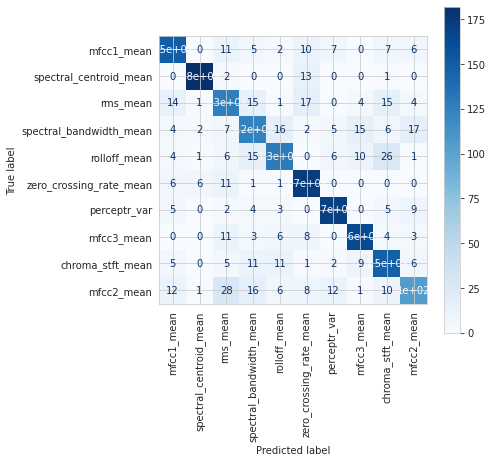

              precision    recall  f1-score   support

           0      0.750     0.758     0.754       198
           1      0.943     0.919     0.931       198
           2      0.603     0.640     0.621       197
           3      0.639     0.626     0.633       198
           4      0.736     0.650     0.690       197
           5      0.746     0.874     0.805       198
           6      0.842     0.859     0.850       198
           7      0.807     0.823     0.815       198
           8      0.667     0.747     0.705       198
           9      0.693     0.525     0.598       198

    accuracy                          0.742      1978
   macro avg      0.742     0.742     0.740      1978
weighted avg      0.743     0.742     0.740      1978



In [59]:
predictProba(xgbc, X_train_rfe, True)

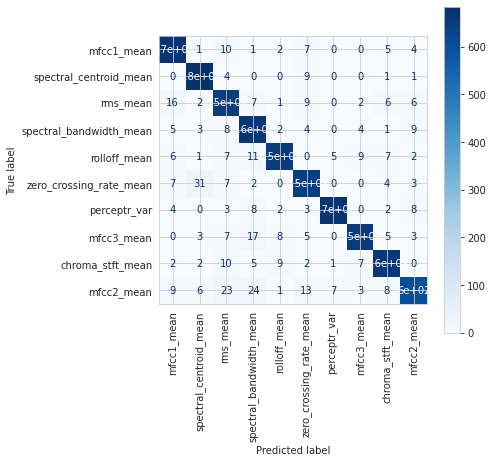

              precision    recall  f1-score   support

           0      0.932     0.957     0.944       700
           1      0.933     0.979     0.955       699
           2      0.891     0.930     0.910       698
           3      0.898     0.948     0.923       699
           4      0.963     0.931     0.947       699
           5      0.926     0.923     0.924       700
           6      0.981     0.957     0.969       700
           7      0.963     0.931     0.947       700
           8      0.944     0.946     0.945       700
           9      0.944     0.865     0.903       698

    accuracy                          0.937      6993
   macro avg      0.938     0.937     0.937      6993
weighted avg      0.938     0.937     0.937      6993



In [60]:
#knn
from sklearn.neighbors import KNeighborsClassifier as knn

cls = knn()
cls.fit(X_train_rfe, y_train)
predictProba(cls, X_train_rfe)

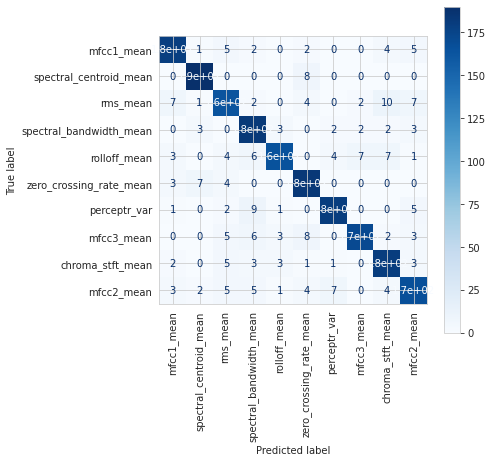

              precision    recall  f1-score   support

           0      0.904     0.904     0.904       198
           1      0.931     0.960     0.945       198
           2      0.845     0.832     0.839       197
           3      0.847     0.924     0.884       198
           4      0.938     0.838     0.885       197
           5      0.872     0.929     0.900       198
           6      0.928     0.909     0.918       198
           7      0.940     0.864     0.900       198
           8      0.861     0.909     0.885       198
           9      0.861     0.843     0.852       198

    accuracy                          0.891      1978
   macro avg      0.893     0.891     0.891      1978
weighted avg      0.893     0.891     0.891      1978



In [61]:
predictProba(cls, X_train_rfe, True)

In [63]:
!pip install catboost
import catboost as cb


     |████████████████████████████████| 69.2MB 38kB/s 


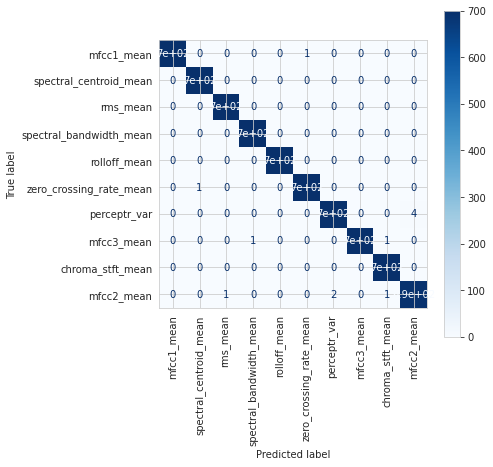

              precision    recall  f1-score   support

           0      1.000     0.999     0.999       700
           1      0.999     1.000     0.999       699
           2      0.999     1.000     0.999       698
           3      0.999     1.000     0.999       699
           4      1.000     1.000     1.000       699
           5      0.999     0.999     0.999       700
           6      0.997     0.994     0.996       700
           7      1.000     0.997     0.999       700
           8      0.997     1.000     0.999       700
           9      0.994     0.994     0.994       698

    accuracy                          0.998      6993
   macro avg      0.998     0.998     0.998      6993
weighted avg      0.998     0.998     0.998      6993



In [64]:
#CAT BOOST
cbc = cb.CatBoostClassifier(random_state=seed, verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
cbc.fit(X_train_rfe, y_train)
predictProba(cbc, X_train_rfe)

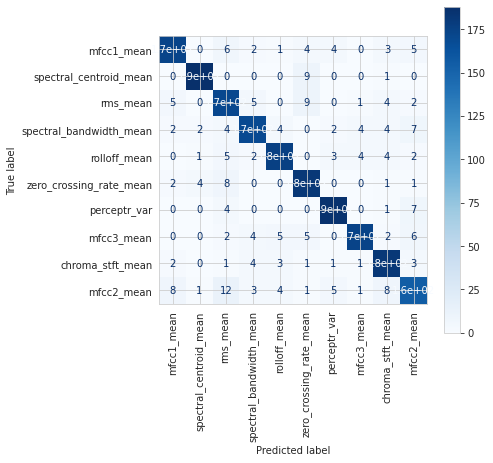

              precision    recall  f1-score   support

           0      0.901     0.874     0.887       198
           1      0.959     0.949     0.954       198
           2      0.803     0.868     0.834       197
           3      0.894     0.854     0.873       198
           4      0.912     0.893     0.903       197
           5      0.863     0.919     0.890       198
           6      0.925     0.939     0.932       198
           7      0.941     0.879     0.909       198
           8      0.867     0.919     0.892       198
           9      0.824     0.783     0.803       198

    accuracy                          0.888      1978
   macro avg      0.889     0.888     0.888      1978
weighted avg      0.889     0.888     0.888      1978



In [65]:
predictProba(cbc, X_train_rfe, True)

In [66]:
#model tuning
#random forest model hyper tuning
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 400, num = 4)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 60, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

print(random_grid)

{'n_estimators': [10, 140, 270, 400], 'max_depth': [1, 15, 30, 45, 60], 'min_samples_split': [5, 10, 15]}


In [67]:
# Use grid search to find best hyperparameters
rfc_n = ske.RandomForestClassifier(random_state=seed, n_jobs=-1)
rf_random = skms.GridSearchCV(estimator = rfc_n, param_grid=random_grid, cv = 5, verbose=2, n_jobs = -1, scoring='f1_weighted')
# Fit the random search model
rf_random.fit(X_train_rfe, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=12,
                                    

In [68]:
# best random model 
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)


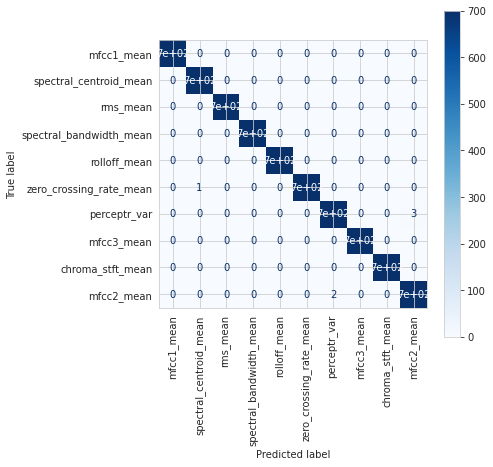

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       700
           1      0.999     1.000     0.999       699
           2      1.000     1.000     1.000       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      1.000     0.999     0.999       700
           6      0.997     0.996     0.996       700
           7      1.000     1.000     1.000       700
           8      1.000     1.000     1.000       700
           9      0.996     0.997     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [69]:
# Performance metrics
predictProba(rf_random.best_estimator_, X_train_rfe)

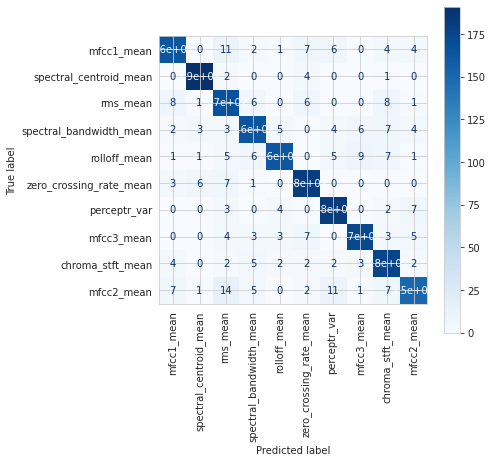

              precision    recall  f1-score   support

           0      0.867     0.823     0.845       198
           1      0.941     0.965     0.953       198
           2      0.766     0.848     0.805       197
           3      0.854     0.828     0.841       198
           4      0.915     0.822     0.866       197
           5      0.866     0.914     0.889       198
           6      0.867     0.919     0.892       198
           7      0.901     0.874     0.887       198
           8      0.819     0.889     0.852       198
           9      0.862     0.758     0.806       198

    accuracy                          0.864      1978
   macro avg      0.866     0.864     0.864      1978
weighted avg      0.866     0.864     0.864      1978



In [70]:
predictProba(rf_random.best_estimator_, X_train_rfe, True)

In [71]:
#XGB model hyper parameter tuning
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=seed)

xgb_params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

In [72]:
# Use the random grid to search for best hyperparameters
xgb_random = skms.RandomizedSearchCV(estimator = xgb_model, param_distributions=xgb_params, n_iter=20, cv = 3, verbose=2, n_jobs = -1, random_state=seed, scoring='f1_weighted', return_train_score=True)
# Fit the random search model
xgb_random.fit(X_train_rfe, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=12, reg_alpha=0,
                                           reg_lambda=1, s...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7769949fd0>,
                                        'n_estimator

In [73]:
# best xgb_random model 
print(xgb_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9066782998097372,
              gamma=0.0016439843761698048, learning_rate=0.3000310498970947,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
              n_estimators=137, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=12, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.6023637423473936, verbosity=1)


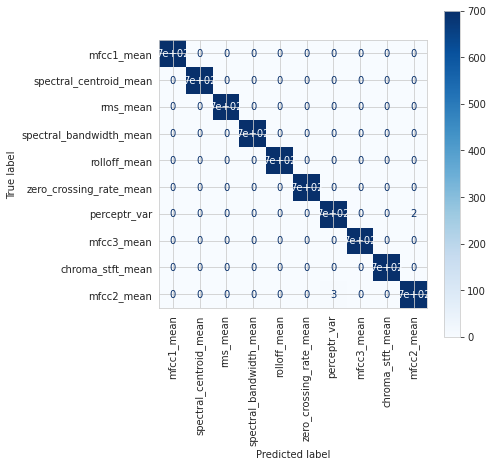

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       700
           1      1.000     1.000     1.000       699
           2      1.000     1.000     1.000       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      1.000     1.000     1.000       700
           6      0.996     0.997     0.996       700
           7      1.000     1.000     1.000       700
           8      1.000     1.000     1.000       700
           9      0.997     0.996     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [74]:
# Performance metrics
predictProba(xgb_random.best_estimator_, X_train_rfe)

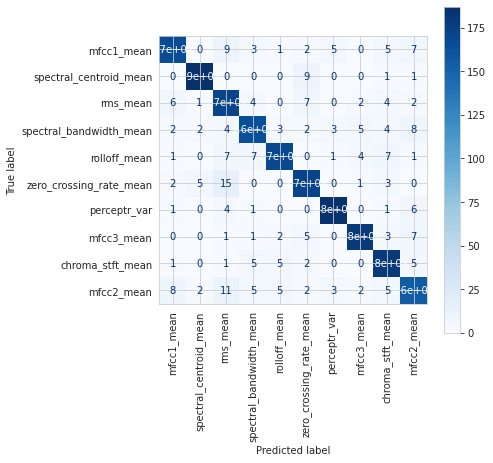

              precision    recall  f1-score   support

           0      0.888     0.838     0.862       198
           1      0.949     0.944     0.947       198
           2      0.767     0.868     0.814       197
           3      0.864     0.833     0.848       198
           4      0.914     0.858     0.885       197
           5      0.856     0.869     0.862       198
           6      0.939     0.934     0.937       198
           7      0.927     0.904     0.916       198
           8      0.844     0.904     0.873       198
           9      0.807     0.783     0.795       198

    accuracy                          0.874      1978
   macro avg      0.876     0.874     0.874      1978
weighted avg      0.876     0.874     0.874      1978



In [75]:
predictProba(xgb_random.best_estimator_, X_train_rfe, True)

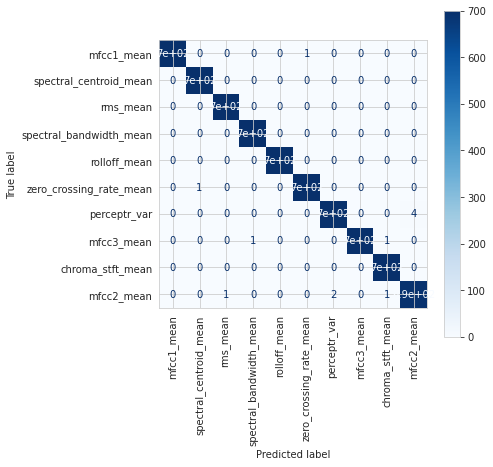

              precision    recall  f1-score   support

           0      1.000     0.999     0.999       700
           1      0.999     1.000     0.999       699
           2      0.999     1.000     0.999       698
           3      0.999     1.000     0.999       699
           4      1.000     1.000     1.000       699
           5      0.999     0.999     0.999       700
           6      0.997     0.994     0.996       700
           7      1.000     0.997     0.999       700
           8      0.997     1.000     0.999       700
           9      0.994     0.994     0.994       698

    accuracy                          0.998      6993
   macro avg      0.998     0.998     0.998      6993
weighted avg      0.998     0.998     0.998      6993



In [77]:
cbc = cb.CatBoostClassifier(random_state=seed, verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
cbc.fit(X_train_rfe, y_train)
predictProba(cbc, X_train_rfe)

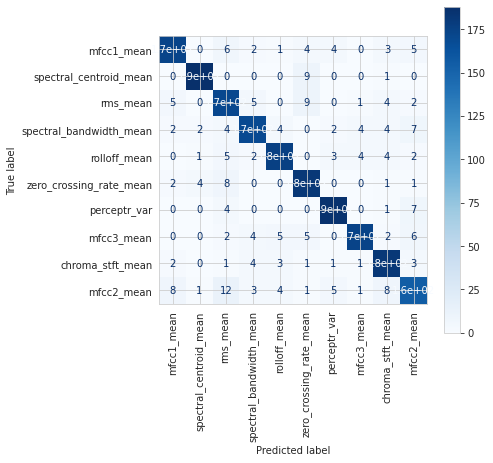

              precision    recall  f1-score   support

           0      0.901     0.874     0.887       198
           1      0.959     0.949     0.954       198
           2      0.803     0.868     0.834       197
           3      0.894     0.854     0.873       198
           4      0.912     0.893     0.903       197
           5      0.863     0.919     0.890       198
           6      0.925     0.939     0.932       198
           7      0.941     0.879     0.909       198
           8      0.867     0.919     0.892       198
           9      0.824     0.783     0.803       198

    accuracy                          0.888      1978
   macro avg      0.889     0.888     0.888      1978
weighted avg      0.889     0.888     0.888      1978



In [76]:
predictProba(cbc, X_train_rfe, True)

In [78]:
#model evaluation
y_pred_X = rf_random.best_estimator_.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("RF Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

           0      0.890     0.873     0.881       102
           1      0.892     0.980     0.934       101
           2      0.810     0.833     0.821       102
           3      0.915     0.843     0.878       102
           4      0.887     0.843     0.864       102
           5      0.871     0.863     0.867       102
           6      0.892     0.971     0.930       102
           7      0.895     0.922     0.908       102
           8      0.853     0.853     0.853       102
           9      0.839     0.765     0.800       102

    accuracy                          0.874      1019
   macro avg      0.874     0.874     0.874      1019
weighted avg      0.874     0.874     0.874      1019

RF Test Accuracy - 87.43866535819431


In [79]:
y_pred_X = xgb_random.best_estimator_.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("XGB Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

           0      0.883     0.892     0.888       102
           1      0.933     0.960     0.946       101
           2      0.739     0.833     0.783       102
           3      0.893     0.902     0.898       102
           4      0.928     0.882     0.905       102
           5      0.871     0.863     0.867       102
           6      0.950     0.941     0.946       102
           7      0.922     0.922     0.922       102
           8      0.929     0.892     0.910       102
           9      0.811     0.755     0.782       102

    accuracy                          0.884      1019
   macro avg      0.886     0.884     0.885      1019
weighted avg      0.886     0.884     0.885      1019

XGB Test Accuracy - 88.42001962708538


In [80]:
y_pred_X = cbc.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("CatBoost Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

           0      0.903     0.912     0.907       102
           1      0.925     0.970     0.947       101
           2      0.789     0.843     0.815       102
           3      0.918     0.873     0.894       102
           4      0.947     0.882     0.914       102
           5      0.883     0.892     0.888       102
           6      0.933     0.961     0.947       102
           7      0.950     0.931     0.941       102
           8      0.895     0.922     0.908       102
           9      0.833     0.784     0.808       102

    accuracy                          0.897      1019
   macro avg      0.898     0.897     0.897      1019
weighted avg      0.898     0.897     0.897      1019

CatBoost Test Accuracy - 89.69578017664377


In [81]:
y_pred_X = cls.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("KNN Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

           0      0.931     0.922     0.926       102
           1      0.874     0.960     0.915       101
           2      0.850     0.833     0.842       102
           3      0.885     0.902     0.893       102
           4      0.944     0.824     0.880       102
           5      0.893     0.902     0.898       102
           6      0.943     0.971     0.957       102
           7      0.904     0.922     0.913       102
           8      0.889     0.941     0.914       102
           9      0.894     0.824     0.857       102

    accuracy                          0.900      1019
   macro avg      0.901     0.900     0.899      1019
weighted avg      0.901     0.900     0.899      1019

KNN Test Accuracy - 89.9901864573111


In [82]:
y_pred_X = lr.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("Logistic Regression Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

           0      0.679     0.706     0.692       102
           1      0.864     0.881     0.873       101
           2      0.593     0.529     0.560       102
           3      0.606     0.618     0.612       102
           4      0.670     0.578     0.621       102
           5      0.730     0.824     0.774       102
           6      0.739     0.863     0.796       102
           7      0.780     0.833     0.806       102
           8      0.634     0.627     0.631       102
           9      0.518     0.422     0.465       102

    accuracy                          0.688      1019
   macro avg      0.681     0.688     0.683      1019
weighted avg      0.681     0.688     0.683      1019

Logistic Regression Test Accuracy - 68.79293424926398
